In [3]:
# ===== Cell 1: Setup & Imports =====

!pip install -q lightgbm

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import csr_matrix, hstack, issparse

import lightgbm as lgb
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ---- PATHS (edit if your folder/file name differs) ----
BASE_DIR   = "/content/drive/MyDrive/Patents Project - Data Science"
CSV_PATH   = f"{BASE_DIR}/all_features_df.csv"           # your engineered feature CSV
TFIDF_PATH = f"{BASE_DIR}/tfidf_features_for_bryant.joblib"     # precomputed TF-IDF aligned to rows

MODEL_SAVE_PATH = f"{BASE_DIR}/lightgbm_102_model.joblib"
RANDOM_STATE    = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===== Cell 2: Load data & define X / y =====

print("--- Loading engineered feature DataFrame ---")
df = pd.read_csv(CSV_PATH)
df = df.reset_index(drop=True)
print(f"Rows: {len(df):,}")
print("First 10 columns:", df.columns[:10].tolist())

# Confirm the key columns exist
required_cols = ["y_101", "y_102", "y_103", "y_112", "claim_text"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in df: {missing}")


--- Loading engineered feature DataFrame ---


In [ ]:
# ---- Target ----
rej_type = "y_102"
y = df[rej_type].astype(int)

print(f"\n--- {rej_type} distribution ---")
print(y.value_counts(normalize=True).mul(100).round(2))
print(y.value_counts())

drop_cols = [
    "y_102", "y_101", "y_103", "y_112", "y_approved",
    "application_number",
    "claim_text",
]

# keep only columns that are not in drop_cols
feature_cols_tabular = [c for c in df.columns if c not in drop_cols]

print("\nNumber of tabular feature columns (non-text):", len(feature_cols_tabular))

# Build tabular numeric/one-hot matrix
X_tab = df[feature_cols_tabular].copy()

print("Tabular feature sample:")
print(X_tab.head())

In [3]:
# ===== Cell 3: Load TF-IDF sparse features =====

print("\n--- Loading TF-IDF matrix from joblib ---")
X_tfidf = joblib.load(TFIDF_PATH)

if not issparse(X_tfidf):
    X_tfidf = csr_matrix(X_tfidf)
    print("Converted TF-IDF to CSR sparse matrix.")

print("TF-IDF shape:", X_tfidf.shape)
print("df rows:", len(df))

if X_tfidf.shape[0] != len(df):
    raise ValueError("Row count mismatch between TF-IDF matrix and df. Check alignment!")



--- Loading TF-IDF matrix from joblib ---
TF-IDF shape: (3909923, 637906)
df rows: 3909923


In [4]:
# ===== Cell 4: Stratified 70/15/15 split on indices =====

indices = df.index.to_series()

train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)

val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

def describe_split(name, yy):
    n = len(yy)
    dist = yy.value_counts(normalize=True).mul(100).round(2)
    c1 = dist.get(1, 0.0)
    c0 = dist.get(0, 0.0)
    print(f"{name:>8} | N={n:>8} | class1={c1:5.2f}% | class0={c0:5.2f}%")

print("\n--- Split summary for y_102 ---")
describe_split("Train", y_train)
describe_split("Val",   y_val)
describe_split("Test",  y_test)



--- Split summary for y_102 ---
   Train | N= 2736946 | class1=63.46% | class0=36.54%
     Val | N=  586488 | class1=63.46% | class0=36.54%
    Test | N=  586489 | class1=63.46% | class0=36.54%


In [5]:
# ===== Cell 5: Build final feature matrices (TF-IDF + tabular) =====

from scipy.sparse import csr_matrix, hstack

train_idx_arr = train_idx.values
val_idx_arr   = val_idx.values
test_idx_arr  = test_idx.values

# --- 1) Slice TF-IDF by split indices ---
X_train_tfidf = X_tfidf[train_idx_arr, :]
X_val_tfidf   = X_tfidf[val_idx_arr, :]
X_test_tfidf  = X_tfidf[test_idx_arr, :]

# --- 2) Filter tabular features to only numeric/boolean ---
# (this avoids scipy.sparse dtype=object error)
X_tab_numeric = X_tab.select_dtypes(include=["int64", "float64", "bool"])
print("Final usable tabular columns:", X_tab_numeric.shape[1])

# --- 3) Slice tabular and convert to sparse (float32 to save RAM) ---
X_train_tab = csr_matrix(X_tab_numeric.iloc[train_idx_arr].values.astype("float32"))
X_val_tab   = csr_matrix(X_tab_numeric.iloc[val_idx_arr].values.astype("float32"))
X_test_tab  = csr_matrix(X_tab_numeric.iloc[test_idx_arr].values.astype("float32"))

# --- 4) Horizontally stack: [TF-IDF | Tabular] ---
X_train_full = hstack([X_train_tfidf, X_train_tab]).tocsr()
X_val_full   = hstack([X_val_tfidf,   X_val_tab]).tocsr()
X_test_full  = hstack([X_test_tfidf,  X_test_tab]).tocsr()

print("Shapes:")
print("X_train_full:", X_train_full.shape)
print("X_val_full:  ", X_val_full.shape)
print("X_test_full: ", X_test_full.shape)


Final usable tabular columns: 219
Shapes:
X_train_full: (2736946, 638125)
X_val_full:   (586488, 638125)
X_test_full:  (586489, 638125)


In [7]:
# ===== Cell 6: Train LightGBM for 102/101 classification =====


import lightgbm as lgb
from sklearn.metrics import classification_report

# ===== 1) Compute imbalance weight =====
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
scale_pos_weight = num_neg / num_pos

print(f"num_pos={num_pos:,}, num_neg={num_neg:,}, scale_pos_weight={scale_pos_weight:.2f}")

# ===== 2) LightGBM params for rejections =====
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 4,
    "min_data_in_leaf": 50,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# ===== 3) Create datasets =====
lgb_train = lgb.Dataset(X_train_full, label=y_train)
lgb_val   = lgb.Dataset(X_val_full,   label=y_val)

# ===== 4) Train w/ EARLY STOPPING (LightGBM 4.x API) =====
gbm = lgb.train(
    params,
    train_set=lgb_train,
    num_boost_round=1000,           # high cap, but early stop will cut earlier
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(50),     # STOP if no validation improvement for 50 rounds
        lgb.log_evaluation(100)     # print metrics every 100 rounds
    ]
)

print("\nBest iteration:", gbm_102.best_iteration)

# ===== 5) Evaluate =====
val_prob  = gbm.predict(X_val_full, num_iteration=gbm.best_iteration)
test_prob = gbm.predict(X_test_full, num_iteration=gbm.best_iteration)

val_pred  = (val_prob >= 0.5).astype(int)
test_pred = (test_prob >= 0.5).astype(int)

print("\nValidation Results:")
print(classification_report(y_val, val_pred))

print("\nTest Results:")
print(classification_report(y_test, test_pred))


num_pos=1,736,840, num_neg=1,000,106, scale_pos_weight=0.58
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.31469	train's auc: 0.934483	valid's binary_logloss: 0.315171	valid's auc: 0.934132
[200]	train's binary_logloss: 0.305943	train's auc: 0.937716	valid's binary_logloss: 0.307493	valid's auc: 0.936864
[300]	train's binary_logloss: 0.302124	train's auc: 0.939371	valid's binary_logloss: 0.304844	valid's auc: 0.937948
[400]	train's binary_logloss: 0.299574	train's auc: 0.940503	valid's binary_logloss: 0.303541	valid's auc: 0.938473
[500]	train's binary_logloss: 0.297589	train's auc: 0.941395	valid's binary_logloss: 0.302774	valid's auc: 0.938764
[600]	train's binary_logloss: 0.295861	train's auc: 0.942163	valid's binary_logloss: 0.302229	valid's auc: 0.938952
[700]	train's binary_logloss: 0.294269	train's auc: 0.942892	valid's binary_logloss: 0.301795	valid's auc: 0.939111
[800]	train's binary_logloss: 0.292827	train's auc: 0.943573	valid's

In [9]:
# Save model

model_name = f"lightgbm_{rej_type}_model"
MODEL_SAVE_PATH = f"{BASE_DIR}/{model_name}.joblib"

gbm.save_model(MODEL_SAVE_PATH)
print(f"\nModel saved to: {MODEL_SAVE_PATH}")


Model saved to: /content/drive/MyDrive/Patents Project - Data Science/lightgbm_102_model.joblib


In [10]:
# ===== Cell 7: Evaluation =====

from sklearn.metrics import classification_report

def print_report(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(classification_report(y_true, y_pred, digits=4))

best_iter = gbm.best_iteration
print("Best iteration from early stopping:", best_iter)

# Predict probabilities
train_prob = gbm.predict(X_train_full, num_iteration=best_iter)
val_prob   = gbm.predict(X_val_full,   num_iteration=best_iter)
test_prob  = gbm.predict(X_test_full,  num_iteration=best_iter)

print_report("Train", y_train, train_prob, threshold=0.5)
print_report("Val",   y_val,   val_prob,   threshold=0.5)
print_report("Test",  y_test,  test_prob,  threshold=0.5)


Best iteration from early stopping: 992

=== Train (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.8088    0.8422    0.8252   1000106
           1     0.9069    0.8854    0.8960   1736840

    accuracy                         0.8696   2736946
   macro avg     0.8579    0.8638    0.8606   2736946
weighted avg     0.8711    0.8696    0.8701   2736946


=== Val (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.8017    0.8342    0.8177    214308
           1     0.9023    0.8812    0.8916    372180

    accuracy                         0.8640    586488
   macro avg     0.8520    0.8577    0.8546    586488
weighted avg     0.8655    0.8640    0.8646    586488


=== Test (threshold=0.50) ===
              precision    recall  f1-score   support

           0     0.8001    0.8327    0.8161    214309
           1     0.9014    0.8802    0.8907    372180

    accuracy                         0.8629    58

In [11]:
# ===== Cell 7: Evaluation on Train / Val / Test updated according to latest cell 6 =====

from sklearn.metrics import classification_report

# Use best_iteration from early stopping (if available)
best_iter = getattr(gbm, "best_iteration", None)
print("Best iteration used for prediction:", best_iter)

def predict_with_best_iter(model, X):
    if best_iter is not None:
        return model.predict(X, num_iteration=best_iter)
    else:
        return model.predict(X)

# Get probabilities for class 1
train_prob = predict_with_best_iter(gbm, X_train_full)
val_prob   = predict_with_best_iter(gbm, X_val_full)
test_prob  = predict_with_best_iter(gbm, X_test_full)

def print_report(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n=== {name} (threshold = {threshold:.2f}) ===")
    print(classification_report(y_true, y_pred, digits=4))

# Default threshold 0.5
print(f"########### Report for {rej_type} ###########")
print_report("Train", y_train, train_prob, threshold=0.5)
print_report("Val",   y_val,   val_prob,   threshold=0.5)
print_report("Test",  y_test,  test_prob,  threshold=0.5)

# (Optional) Try a couple of alternative thresholds for Test
for thr in [0.3, 0.4, 0.5, 0.6]:
    print_report(f"Test @ threshold={thr:.2f}", y_test, test_prob, threshold=thr)


Best iteration used for prediction: 992

=== Train (threshold = 0.50) ===
              precision    recall  f1-score   support

           0     0.8088    0.8422    0.8252   1000106
           1     0.9069    0.8854    0.8960   1736840

    accuracy                         0.8696   2736946
   macro avg     0.8579    0.8638    0.8606   2736946
weighted avg     0.8711    0.8696    0.8701   2736946


=== Val (threshold = 0.50) ===
              precision    recall  f1-score   support

           0     0.8017    0.8342    0.8177    214308
           1     0.9023    0.8812    0.8916    372180

    accuracy                         0.8640    586488
   macro avg     0.8520    0.8577    0.8546    586488
weighted avg     0.8655    0.8640    0.8646    586488


=== Test (threshold = 0.50) ===
              precision    recall  f1-score   support

           0     0.8001    0.8327    0.8161    214309
           1     0.9014    0.8802    0.8907    372180

    accuracy                         0.8629

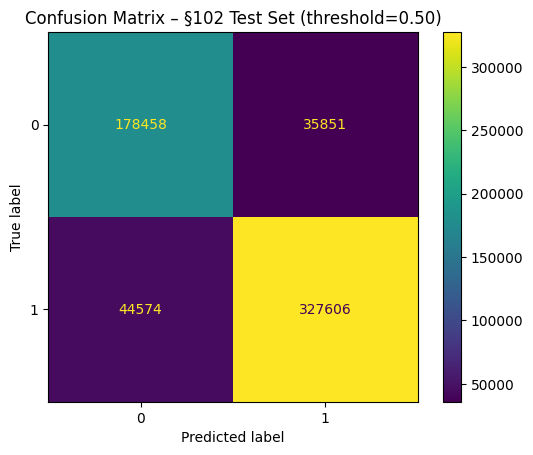

Confusion matrix (rows = true, cols = predicted):
 [[178458  35851]
 [ 44574 327606]]


In [12]:
# ===== Cell 8: Confusion Matrix on Test Set =====

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Choose threshold (can change if you like)
THRESH = 0.5

test_pred = (test_prob >= THRESH).astype(int)
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix – {rej_type} Test Set (threshold={THRESH:.2f})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

print("Confusion matrix (rows = true, cols = predicted):\n", cm)


In [13]:
# ===== Cell 9: Global Feature Importance (Top K) =====

import numpy as np

# Get raw importance scores from LightGBM
importance = gbm.feature_importance(importance_type="gain")
indices = np.argsort(importance)[::-1]  # descending

n_total_features = len(importance)
n_tfidf_features = X_tfidf.shape[1]
n_tab_features   = X_tab_numeric.shape[1]

print(f"Total features in model: {n_total_features}")
print(f"TF-IDF feature count: {n_tfidf_features}")
print(f"Tabular feature count: {n_tab_features}")

# Sanity check
assert n_total_features == n_tfidf_features + n_tab_features, \
    "Mismatch between TF-IDF + tabular features and model feature count."

# Map indices back to human-readable names
def feature_name_from_index(idx):
    if idx < n_tfidf_features:
        # We don't have the actual vocabulary mapping here, so label generically
        return f"TFIDF_term_{idx}"
    else:
        tab_idx = idx - n_tfidf_features
        return X_tab_numeric.columns[tab_idx]

top_k = 30
print(f"\nTop {top_k} features by gain:")

for rank, idx in enumerate(indices[:top_k], start=1):
    if importance[idx] <= 0:
        continue
    name = feature_name_from_index(idx)
    print(f"{rank:2d}. {name:60s}  gain={importance[idx]:.4f}")


Total features in model: 638125
TF-IDF feature count: 637906
Tabular feature count: 219

Top 30 features by gain:
 1. unique_rej_types                                              gain=10068921.8157
 2. number_of_oa                                                  gain=727436.9391
 3. groupartunitnumber_x                                          gain=360889.9698
 4. aia_first_to_file_False                                       gain=228333.9221
 5. art_unit_cat_Semiconductors/Memory, Circuits/Measuring and Testing, Optics/Photocopying, Printing/Measuring and Testing  gain=70190.0181
 6. TFIDF_term_111545                                             gain=64905.6538
 7. oa_span_days                                                  gain=57643.9524
 8. max_gap_days                                                  gain=56519.9277
 9. TFIDF_term_331563                                             gain=52719.0248
10. years_since_pub                                               gain=46563.7046
1